In [1]:
!python -V

Python 3.11.9


In [1]:
import pandas as pd
import  seaborn as sns
import matplotlib.pyplot as plt

In [47]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error, root_mean_squared_error

In [3]:
path_data = "../../DataSets/green_tripdata_2021-01.parquet"

In [50]:
df = pd.read_parquet(path_data)

In [51]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [52]:
df.shape

(76518, 20)

In [53]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [54]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [55]:
df.shape

(73908, 21)

In [56]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

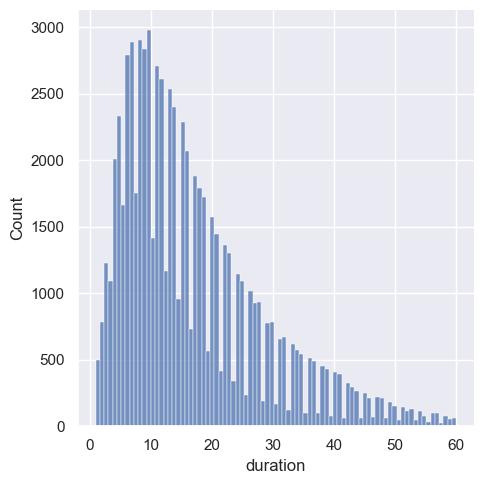

In [57]:
sns.displot(df.duration)

In [58]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [59]:
from sklearn.metrics import mean_squared_error

train_dicts = df[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

# Calcul du RMSE
rmse = root_mean_squared_error(y_train, y_pred) ##Depreciate mean_squared_error
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 9.838799799829628


In [60]:
sns.set_theme()

<Axes: ylabel='Count'>

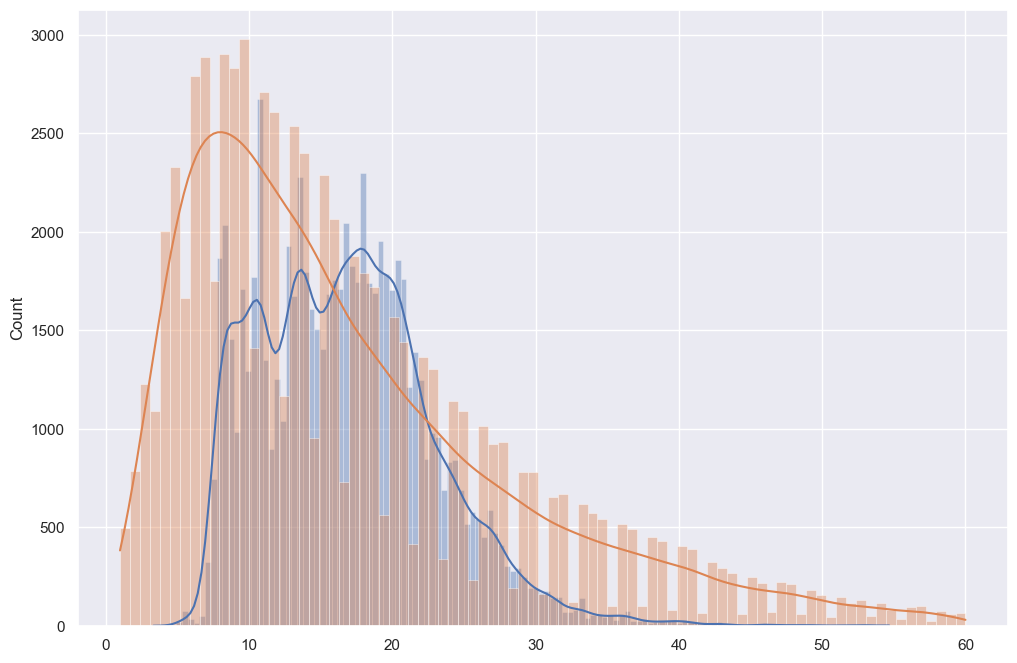

In [61]:
sns.histplot(y_pred, kde=True, label='prediction', alpha=.4, edgecolor=(1, 1, 1, .4))
sns.histplot(y_train, kde=True, label='actual', alpha=.4, edgecolor=(1, 1, 1, .4))

<Axes: ylabel='Density'>

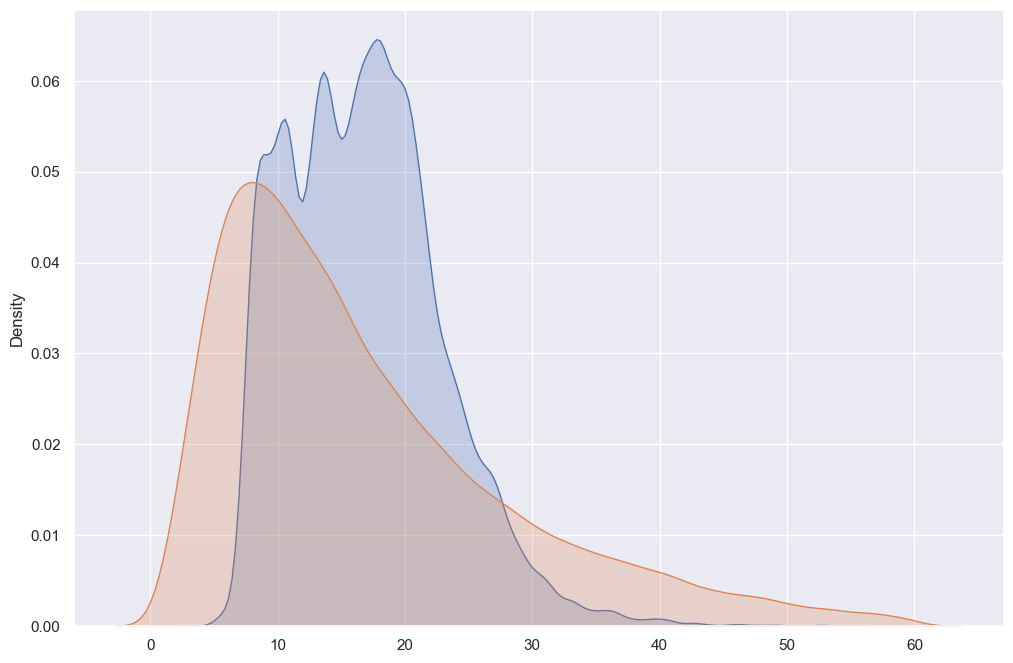

In [62]:
# Utilisation de kdeplot pour les prédictions
sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_train, label='actual', fill=True)

In [63]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        dataframe = pd.read_csv(filename)

        dataframe.lpep_dropoff_datetime = pd.to_datetime(dataframe.lpep_dropoff_datetime)
        dataframe.lpep_pickup_datetime = pd.to_datetime(dataframe.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        dataframe = pd.read_parquet(filename)

    dataframe['duration'] = dataframe.lpep_dropoff_datetime - dataframe.lpep_pickup_datetime
    dataframe.duration = dataframe.duration.apply(lambda td: td.total_seconds() / 60)

    dataframe = dataframe[(dataframe.duration >= 1) & (dataframe.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    dataframe[categorical] = dataframe[categorical].astype(str)

    return dataframe

In [64]:
df_train = read_dataframe("../../DataSets/green_tripdata_2021-01.parquet")
df_val = read_dataframe("../../DataSets/green_tripdata_2021-02.parquet")

In [65]:
len(df_train), len(df_val)

(73908, 61921)

In [66]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [67]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [68]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [69]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715200888857

In [70]:
import pickle

In [71]:
# Sauvegarde du modèle et du transformateur de vecteurs (dv) avec pickle
with open('../02-experiment-tracking/models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [72]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

11.167275941179728